In [1]:
import pandas as pd
import numpy as np
from kiteconnect import KiteConnect, KiteTicker
import login
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import pytz
import pymongo
import threading
import os

In [2]:
# Access environment variables
user_name = os.getenv("KITE_USER_NAME")
password = os.getenv("KITE_PASSWORD")
totp = os.getenv("KITE_TOTP")
api_key = os.getenv("KITE_API_KEY")
api_secret = os.getenv("KITE_API_SECRET")

kite = KiteConnect(api_key=api_key)
request_token = login.kiteLogin(user_name, password, totp, api_key)
data = kite.generate_session(request_token, api_secret)
kite.set_access_token(data["access_token"])

In [3]:
instrument_dump = kite.instruments()   # get instruments dump from NSE
instrument_df = pd.DataFrame(instrument_dump)  # dump it to a dataframe
print(instrument_df.columns)

Index(['instrument_token', 'exchange_token', 'tradingsymbol', 'name',
       'last_price', 'expiry', 'strike', 'tick_size', 'lot_size',
       'instrument_type', 'segment', 'exchange'],
      dtype='object')


In [4]:
def getInstrumentToken(symbol):
    #return none if not found
    if len(instrument_df[(instrument_df['tradingsymbol']==symbol) & (instrument_df['exchange']=='NSE')]['instrument_token'].values)==0:
        return None
    return instrument_df[(instrument_df['tradingsymbol']==symbol) & (instrument_df['exchange']=='NSE')]['instrument_token'].values[0]

In [5]:
#get the list of finserv stocks from instrument dump
bse_stocks=pd.read_csv('bse.csv')
#keep only Financial Services stocks
bse_stocks=bse_stocks[bse_stocks['Sector Name']=='Financial Services']
#reset the index
bse_stocks.reset_index(drop=True,inplace=True)

token_list=[]
#get the security id and check if it is present in the instrument dump with exchange as NSE
for index, row in bse_stocks.iterrows():
    symbol=row['Security Id']
    # print(symbol)
    token=getInstrumentToken(symbol)
    # print(token)
    if token:
        # print(symbol,token)
        token_list.append(token)
    else:
        # print('Token not found for symbol:',symbol)
        #remove the row from the dataframe
        bse_stocks.drop(index,inplace=True)

#add token list to the dataframe
bse_stocks['Token']=token_list
#remove if Industry == Mutual Fund Scheme - ETF
final_env=bse_stocks[bse_stocks['Industry']!='Mutual Fund Scheme - ETF'].copy()
#reset the index
final_env.reset_index(drop=True,inplace=True)
#set the index to 'Security Id'
final_env.set_index('Security Id',inplace=True)
#first sort accourding to 'Security Id' and then 'Industry'
final_env.sort_values(by=['Industry','Security Id'],inplace=True)
print(final_env)

             Security Code                                 Issuer Name  \
Security Id                                                              
ABSLAMC             543374           Aditya Birla Sun Life AMC Limited   
HDFCAMC             541729       HDFC Asset Management Company Limited   
IVC                 511208            IL & FS Investment Managers Ltd.   
NAM-INDIA           540767  NIPPON LIFE INDIA ASSET MANAGEMENT LIMITED   
UTIAMC              543238        UTI Asset Management Company Limited   
...                    ...                                         ...   
MOTILALOFS          532892    Motilal Oswal Financial Services Limited   
NUVAMA              543988            Nuvama Wealth Management Limited   
ONELIFECAP          533632                Onelife Capital Advisors Ltd   
SHAREINDIA          540725              Share India Securities Limited   
SMCGLOBAL           543263               SMC Global Securities Limited   

                                     

In [6]:
def calculate_moment_score(df):
    if len(df) < 2:
        return np.nan
    # Get the pct change from the first to the last value
    pct_change = (df['close'].iloc[-1] / df['close'].iloc[0] - 1)
    # Get the std of pct change
    pct_change_std = np.std(df['close'].pct_change())
    if pct_change_std == 0:
        return np.nan
    score_value = pct_change / pct_change_std
    return score_value


#fuction to get zscore accourding to each column
def get_zscore(df):
    for column in df.columns:
        # print(df[column])
        df[column] = (df[column] - df[column].mean())/df[column].std()
    return df
    

def get_moment_score(df,date):
        moment_dict = {}
        # print(df.head(10))
        symbollist = df.index.to_list()
        # print(symbollist)
        end_date = datetime.strptime(date, '%Y-%m-%d')
        start_date = end_date - relativedelta(months=6)
        start_date = start_date.strftime('%Y-%m-%d')

        for symbol in symbollist:
            # print(symbol)

            try:
                stock_data = kite.historical_data(getInstrumentToken(symbol), start_date, end_date, "day")
                #make dataframe of the stock data
                stock_data = pd.DataFrame(stock_data)
                data_points = len(stock_data)
                three_month = stock_data.tail(data_points//2)
                data_points = len(three_month)
                one_month = three_month.tail(data_points//3)
                data_points = len(one_month)
                two_week = one_month.tail(data_points//2)
                data_points = len(two_week)
                one_week = stock_data.tail(5)
                three_days = stock_data.tail(3) 


                socre_t = calculate_moment_score(stock_data)
                score_3m = calculate_moment_score(three_month)
                score_1m = calculate_moment_score(one_month)
                score_2w = calculate_moment_score(two_week)
                score_1w = calculate_moment_score(one_week)
                score_3d = calculate_moment_score(three_days)

                # print(socre_t,score_3m,score_1m,score_2w,score_1w,score_3d)

                row={'score_t':socre_t,'score_3m':score_3m,'score_1m':score_1m,'score_2w':score_2w,'score_1w':score_1w,'score_3d':score_3d}
                moment_dict[symbol] = row

            except:
                # print("Error in getting data for symbol: ", symbol)
                moment_dict[symbol] = {"Z_score_t": np.nan, "Z_score_3m": np.nan, "Z_score_1m": np.nan, "Z_score_2w": np.nan, "Z_score_1w": np.nan, "Z_score_3d": np.nan}

        moment_score_results = pd.DataFrame(moment_dict).T
        # print(moment_score_results)
        moment_score_results = get_zscore(moment_score_results)
        return moment_score_results
        # df['Moment Score'] = moment_score_results['Moment_score']

        # return df

# get the moment score for the stocks
date='2024-01-08'
moment_score_df = get_moment_score(final_env,date)

In [7]:
final_env.loc[:, 'Industry'] = final_env['Industry'].str.strip()
final_env.loc[:, 'Igroup Name'] = final_env['Igroup Name'].str.strip()

moment_score_df['Industry']=final_env['Industry']
moment_score_df['Igroup Name']=final_env['Igroup Name']
print(moment_score_df)


             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
ABSLAMC     0.638894  0.053595 -0.142549 -0.018980  0.079471  0.094883   
HDFCAMC     1.266368  1.357632  2.393767  0.219844  0.262090  0.113345   
IVC        -0.095708  0.655515  0.431155  0.024462 -0.261702  0.153922   
NAM-INDIA   1.637225  1.476182  0.445489  0.140156 -0.108438  0.086463   
UTIAMC     -0.498275  0.254335  0.287563  0.254184  0.160529  0.047315   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  1.270330  1.272348  0.738762  0.133478  1.164877  0.302134   
NUVAMA     -0.203966 -0.177699 -1.180680 -0.091137 -0.477336  0.049256   
ONELIFECAP -0.374812 -0.810417 -2.145724 -0.052284 -0.384558 -0.009702   
SHAREINDIA  0.760685  1.144802 -0.058873 -0.002390 -0.377452  0.045361   
SMCGLOBAL   0.443554  0.682317 -1.146651  0.047151 -0.140771  0.086444   

                            Industry      Igroup Name  
ABSLAMC     Asset Management Company  Capital Markets  

In [8]:
#calulate beta for each stock
def get_beta(stock_df, market_df):
    try:
        stock_df['Returns'] = stock_df['close'].pct_change()

        market_df['Market Returns'] = market_df['close'].pct_change()

        stock_df = stock_df.dropna()
        stock_df = stock_df.reset_index(drop=True)

        market_df = market_df.dropna()
        market_df = market_df.reset_index(drop=True)

        beta = np.cov(stock_df['Returns'], market_df['Market Returns'])[0][1] / np.var(market_df['Market Returns'])
    except:
        beta = np.nan
    # print(beta)
    return beta

def calculate_returns(stock_df):
    if stock_df.empty or 'close' not in stock_df.columns or len(stock_df) < 2:
        return None
    stock_return = stock_df['close'].iloc[-1] / stock_df['close'].iloc[0] - 1
    return stock_return

def calculate_expected_returns(beta,market_return):
    rfr=0.07
    expected_return=rfr+beta*(market_return-rfr)
    return expected_return

def calculate_risk_std(stock_df):
    if stock_df.empty or 'close' not in stock_df.columns or len(stock_df) < 2:
        return None
    stock_return = stock_df['close'].pct_change()
    stock_return_std = np.std(stock_return)
    return stock_return_std


def get_beta_score(df,date):
        
    # print(df.head(10))
    symbollist = df.index.to_list()
    # print(symbollist)
    end_date = datetime.strptime(date, '%Y-%m-%d')
    start_date = end_date - relativedelta(years=1)
    start_date = start_date.strftime('%Y-%m-%d')

    beta_dict={}
    i=0

    one_year_market_data = kite.historical_data(getInstrumentToken('NIFTY 50'), start_date, end_date, "day")
    #make dataframe of the stock data
    one_year_market_data = pd.DataFrame(one_year_market_data)
    data_points = len(one_year_market_data)
    six_month_market_data = one_year_market_data.tail(data_points//2)
    data_points = len(six_month_market_data)
    three_month_market_data = six_month_market_data.tail(data_points//2)
    data_points = len(three_month_market_data)
    one_month_market_data = three_month_market_data.tail(data_points//3)
    data_points = len(one_month_market_data)
    two_week_market_data = one_month_market_data.tail(data_points//2)
    data_points = len(two_week_market_data)
    one_week_market_data = one_month_market_data.tail(5)

    #calulate returns for each time period
    market_return_1y=calculate_returns(one_year_market_data)
    market_return_6m=calculate_returns(six_month_market_data)
    market_return_3m=calculate_returns(three_month_market_data)
    market_return_1m=calculate_returns(one_month_market_data)
    market_return_2w=calculate_returns(two_week_market_data)
    market_return_1w=calculate_returns(one_week_market_data)    

    market_returns={'market_return_1y':market_return_1y,'market_return_6m':market_return_6m,'market_return_3m':market_return_3m,'market_return_1m':market_return_1m,'market_return_2w':market_return_2w,'market_return_1w':market_return_1w}    

    data_points = len(one_year_market_data)
    for symbol in symbollist:
        # print(symbol)
        one_year_stock_data = kite.historical_data(getInstrumentToken(symbol), start_date, end_date, "day")
        #make dataframe of the stock data
        one_year_stock_data = pd.DataFrame(one_year_stock_data)
        data_points = len(one_year_stock_data)



        #6 month data
        six_month_stock_data = one_year_stock_data.tail(data_points//2)
        # data_points = len(six_month_stock_data)
        six_month_market_data = one_year_market_data.tail(data_points//2)
        data_points = len(six_month_market_data)
        #reset the index
        six_month_stock_data.reset_index(drop=True,inplace=True)
        six_month_market_data.reset_index(drop=True,inplace=True)

        #3 month data
        three_month_stock_data = six_month_stock_data.tail(data_points//2)
        # data_points = len(three_month_stock_data)
        three_month_market_data = six_month_market_data.tail(data_points//2)
        data_points = len(three_month_market_data)

        #1 month data
        one_month_stock_data = three_month_stock_data.tail(data_points//3)
        # data_points = len(one_month_stock_data)
        one_month_market_data = three_month_market_data.tail(data_points//3)
        data_points = len(one_month_market_data)

        #2 week data
        two_week_stock_data = one_month_stock_data.tail(data_points//2)
        # data_points = len(two_week_stock_data)
        two_week_market_data = one_month_market_data.tail(data_points//2)
        data_points = len(two_week_market_data)

        #1 week data
        one_week_stock_data = one_month_stock_data.tail(5)
        # data_points = len(one_week_stock_data)
        one_week_market_data = one_month_market_data.tail(5)
        data_points = len(one_week_market_data)

        one_year_beta=get_beta(one_year_stock_data,one_year_market_data)
        six_month_beta=get_beta(six_month_stock_data,six_month_market_data)
        three_month_beta=get_beta(three_month_stock_data,three_month_market_data)
        one_month_beta=get_beta(one_month_stock_data,one_month_market_data)
        two_week_beta=get_beta(two_week_stock_data,two_week_market_data)
        one_week_beta=get_beta(one_week_stock_data,one_week_market_data)

        #calculate returns for each time period
        stock_return_1y=calculate_returns(one_year_stock_data)
        stock_return_6m=calculate_returns(six_month_stock_data)
        stock_return_3m=calculate_returns(three_month_stock_data)
        stock_return_1m=calculate_returns(one_month_stock_data)
        stock_return_2w=calculate_returns(two_week_stock_data)
        stock_return_1w=calculate_returns(one_week_stock_data)

        #calulate expected returns
        expected_return_1y=calculate_expected_returns(one_year_beta,market_return_1y)
        expected_return_6m=calculate_expected_returns(six_month_beta,market_return_6m)
        expected_return_3m=calculate_expected_returns(three_month_beta,market_return_3m)
        expected_return_1m=calculate_expected_returns(one_month_beta,market_return_1m)
        expected_return_2w=calculate_expected_returns(two_week_beta,market_return_2w)
        expected_return_1w=calculate_expected_returns(one_week_beta,market_return_1w)

        risk=calculate_risk_std(three_month_stock_data)


        row={'beta_1y':one_year_beta,'beta_6m':six_month_beta,'beta_3m':three_month_beta,'beta_1m':one_month_beta,'beta_2w':two_week_beta,'beta_1w':one_week_beta,
             'stock_return_1y':stock_return_1y,'stock_return_6m':stock_return_6m,'stock_return_3m':stock_return_3m,'stock_return_1m':stock_return_1m,'stock_return_2w':stock_return_2w,'stock_return_1w':stock_return_1w,
             'expected_return_1y':expected_return_1y,'expected_return_6m':expected_return_6m,'expected_return_3m':expected_return_3m,'expected_return_1m':expected_return_1m,'expected_return_2w':expected_return_2w,'expected_return_1w':expected_return_1w,'risk':risk}
        beta_dict[symbol] = row

    beta_df=pd.DataFrame(beta_dict).T
    print(beta_df)
    return beta_df,market_returns
date='2024-01-08'
beta_score_df,market_return=get_beta_score(final_env,date)

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\692585531.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\692585531.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_df['Market Returns'] = market_df['close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\692585531.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

             beta_1y   beta_6m   beta_3m   beta_1m   beta_2w   beta_1w  \
ABSLAMC     0.335886  0.090517  0.029043 -0.116454  0.445703  1.046161   
HDFCAMC     1.110295  0.898997  0.543674  0.157707  0.312262  1.069487   
IVC         1.098125  1.718533  2.514361  5.005357  0.206752  0.912036   
NAM-INDIA   0.786604  0.528016  0.533354 -0.719127  0.638921  4.199204   
UTIAMC      0.939887  0.959488  0.869949  0.735831  0.468016  0.720700   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  0.997605  0.844564  0.901809  0.099111 -0.901633  1.492944   
NUVAMA           NaN  1.230891  1.824391  3.041171       NaN  3.041171   
ONELIFECAP  0.761358  0.717574  0.536386  0.683516  0.382651 -0.349915   
SHAREINDIA  0.699246  0.475364  0.366812  0.733057  1.029677  0.785777   
SMCGLOBAL   0.403411  0.491989  0.572133  1.025449  1.227699  2.233207   

            stock_return_1y  stock_return_6m  stock_return_3m  \
ABSLAMC            0.047593         0.247754  

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\692585531.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Returns'] = stock_df['close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\692585531.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_df['Market Returns'] = market_df['close'].pct_change()
C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\692585531.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [9]:
print(beta_score_df)

             beta_1y   beta_6m   beta_3m   beta_1m   beta_2w   beta_1w  \
ABSLAMC     0.335886  0.090517  0.029043 -0.116454  0.445703  1.046161   
HDFCAMC     1.110295  0.898997  0.543674  0.157707  0.312262  1.069487   
IVC         1.098125  1.718533  2.514361  5.005357  0.206752  0.912036   
NAM-INDIA   0.786604  0.528016  0.533354 -0.719127  0.638921  4.199204   
UTIAMC      0.939887  0.959488  0.869949  0.735831  0.468016  0.720700   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  0.997605  0.844564  0.901809  0.099111 -0.901633  1.492944   
NUVAMA           NaN  1.230891  1.824391  3.041171       NaN  3.041171   
ONELIFECAP  0.761358  0.717574  0.536386  0.683516  0.382651 -0.349915   
SHAREINDIA  0.699246  0.475364  0.366812  0.733057  1.029677  0.785777   
SMCGLOBAL   0.403411  0.491989  0.572133  1.025449  1.227699  2.233207   

            stock_return_1y  stock_return_6m  stock_return_3m  \
ABSLAMC            0.047593         0.247754  

In [10]:
def get_alpha_score(beta,market_return,stock_return):
    rfr=0.07
    expected_return=rfr+beta*(market_return-rfr)
    jensen_alpha=stock_return-expected_return
    return jensen_alpha


def calculate_alpha_score(beta_score_df,market_return):
    alpha_score={}
    for index,row in beta_score_df.iterrows():
        for time_period in ['1y','6m','3m','1m','2w','1w']:
            beta=row['beta_'+time_period]
            stock_return=row['stock_return_'+time_period]
            #market return is a dictionary
            market_returns=market_return['market_return_'+time_period]
            alpha=get_alpha_score(beta,market_returns,stock_return)
            beta_score_df.loc[index,'alpha_'+time_period]=alpha

            #calculate zscore for columns containing alpha
    zscore=get_zscore(beta_score_df[['alpha_1y','alpha_6m','alpha_3m','alpha_1m','alpha_2w','alpha_1w']])
    
    return zscore

alpha_score_df=calculate_alpha_score(beta_score_df,market_return)


C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\4193093676.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = (df[column] - df[column].mean())/df[column].std()


In [11]:
print(alpha_score_df)

            alpha_1y  alpha_6m  alpha_3m  alpha_1m  alpha_2w  alpha_1w
ABSLAMC    -0.780455 -0.206214 -0.240480 -0.712177 -0.387231 -0.183725
HDFCAMC     0.050865  0.204954  0.271899  0.168875 -0.060450 -0.044353
IVC         0.186500  0.128168  1.465402  2.335177 -0.422477 -0.310236
NAM-INDIA   0.815846  0.597462  0.793855 -0.501742  0.212712  1.296116
UTIAMC     -0.876107 -0.701729 -0.231897 -0.147602 -0.125175 -0.339291
...              ...       ...       ...       ...       ...       ...
MOTILALOFS  0.737990  1.110479  1.157280  0.046171 -0.654991  0.425383
NUVAMA           NaN -0.674394 -0.923169  0.002547       NaN  0.539582
ONELIFECAP -0.673901  0.082024 -0.379121 -1.590979 -0.528750 -0.966631
SHAREINDIA  0.079436  0.276529  0.579718 -0.414149 -0.027891 -0.368693
SMCGLOBAL  -0.215033  0.168963  0.726966 -0.743848  0.182803  0.347277

[183 rows x 6 columns]


In [12]:
#show avg value and standard deviation for each moment score and alpha score if there are numeric columns
print(moment_score_df.describe())
print(alpha_score_df.describe())

            score_t      score_3m      score_1m      score_2w      score_1w  \
count  1.730000e+02  1.730000e+02  1.710000e+02  1.690000e+02  1.730000e+02   
mean  -1.283495e-17  2.053592e-17  4.674623e-17 -3.153296e-17  4.107183e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.703888e+00 -1.994402e+00 -2.177196e+00 -1.272102e+01 -9.290841e+00   
25%   -6.332220e-01 -7.073437e-01 -5.866792e-01 -3.637760e-02 -3.774520e-01   
50%   -1.163358e-01 -1.410115e-01 -1.034458e-01  8.428754e-02 -6.760021e-02   
75%    4.553086e-01  6.555145e-01  4.803711e-01  1.658296e-01  4.213315e-01   
max    5.241048e+00  3.901976e+00  4.325378e+00  6.792170e-01  2.693129e+00   

           score_3d  
count  1.730000e+02  
mean   1.026796e-17  
std    1.000000e+00  
min   -9.146189e+00  
25%   -1.456031e-02  
50%    6.246739e-02  
75%    1.382058e-01  
max    5.330157e+00  
           alpha_1y      alpha_6m      alpha_3m      alpha_1m      alpha_2w  \
count  1.60

In [13]:
#normalize the alpha and moment score
def normalize(df):
    for column in df.columns:
        for index in df.index:
            val=df.loc[index,column]
            if val==np.nan:
                df.loc[index,column]=0
            elif val>0:
                df.loc[index,column]=1+val
            else:
                df.loc[index,column]=1/(1-val)
    return df

moment_score_df=normalize(moment_score_df[['score_t','score_3m','score_1m','score_2w','score_1w','score_3d']])
alpha_score_df=normalize(alpha_score_df[['alpha_1y','alpha_6m','alpha_3m','alpha_1m','alpha_2w','alpha_1w']])

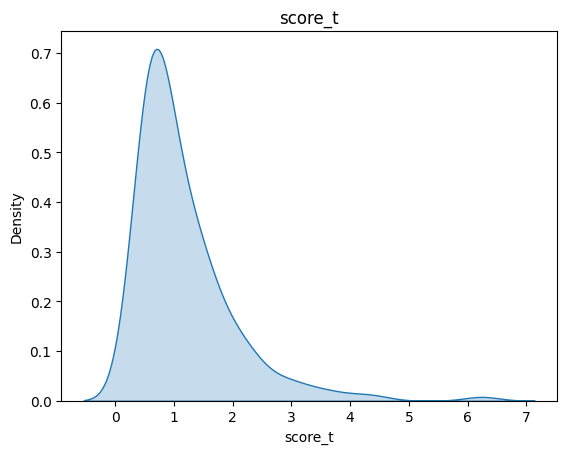

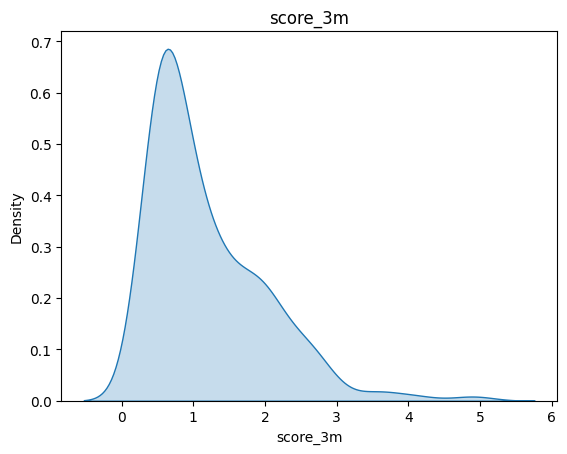

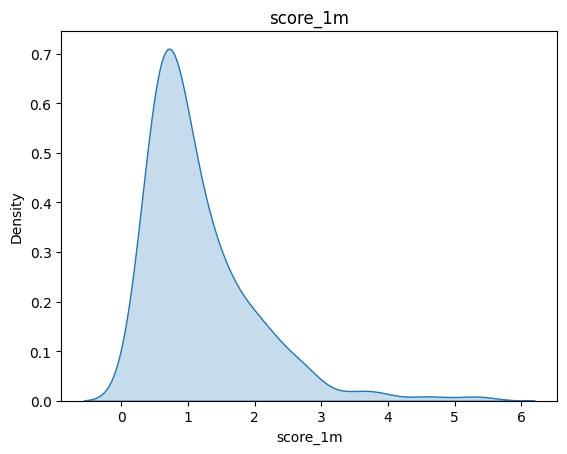

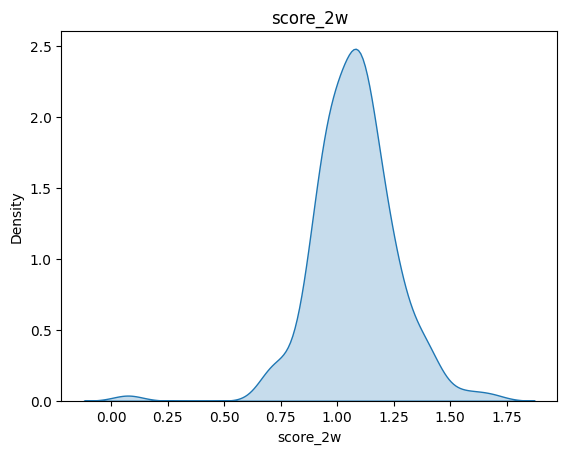

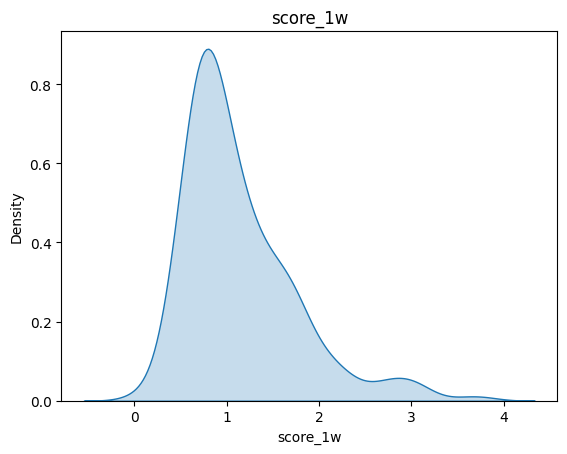

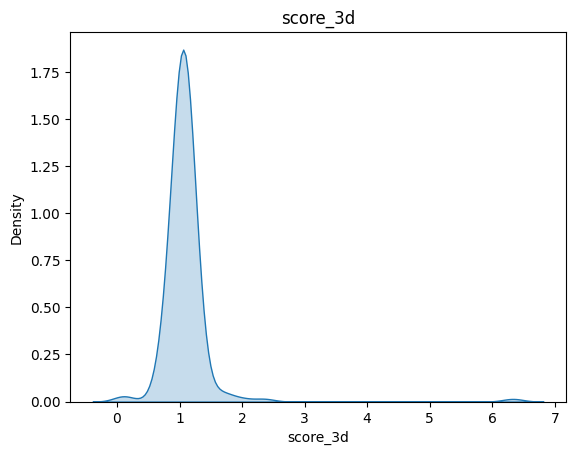

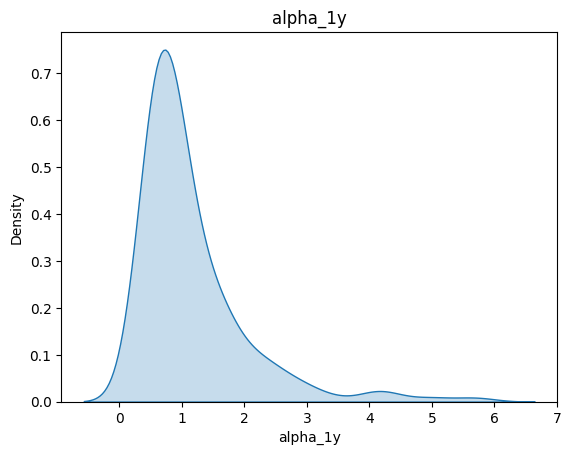

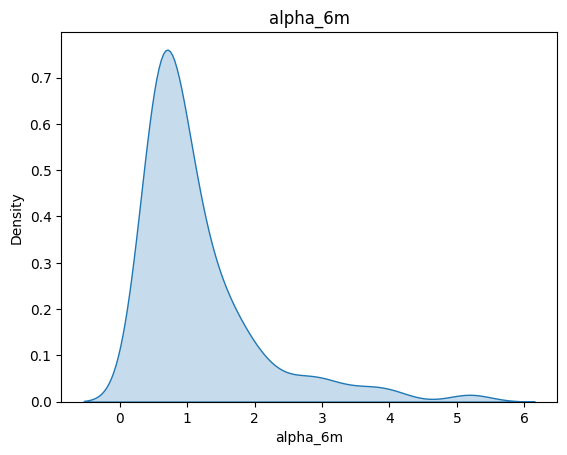

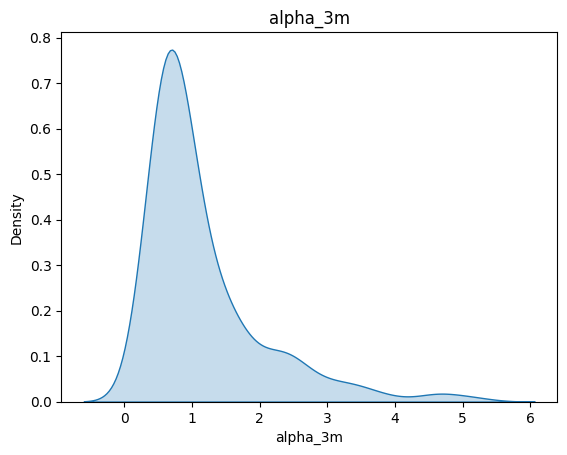

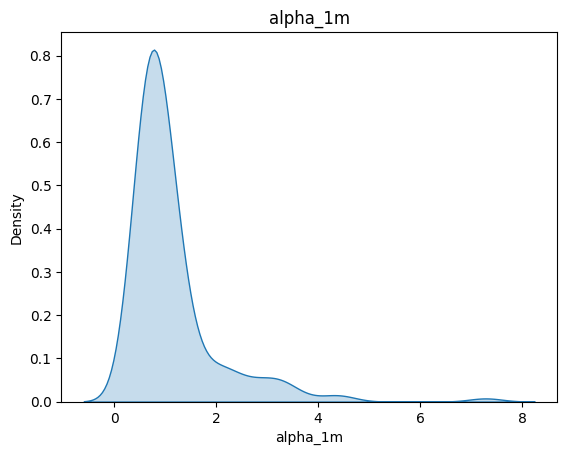

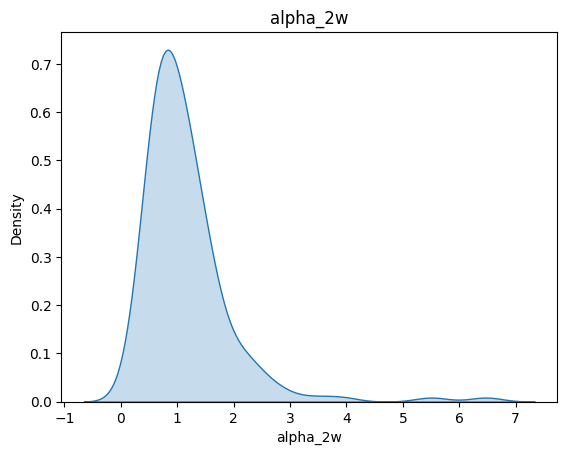

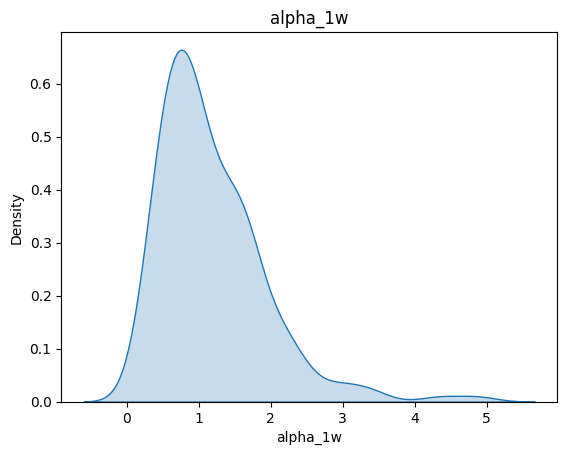

In [14]:
# Plot normal distribution for each moment score and alpha score
import seaborn as sns
import matplotlib.pyplot as plt

for column in moment_score_df.columns:
    if moment_score_df[column].dtype == 'float64':
        sns.kdeplot(moment_score_df[column], fill=True)
        plt.title(column)
        plt.show()

for column in alpha_score_df.columns:
    if alpha_score_df[column].dtype == 'float64':
        sns.kdeplot(alpha_score_df[column], fill=True)
        plt.title(column)
        plt.show()

In [15]:
#add column of alpha and moment score to the final score 
final_score_df=pd.concat([moment_score_df,alpha_score_df],axis=1)
print(final_score_df)

             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
ABSLAMC     1.638894  1.053595  0.875236  0.981373  1.079471  1.094883   
HDFCAMC     2.266368  2.357632  3.393767  1.219844  1.262090  1.113345   
IVC         0.912652  1.655515  1.431155  1.024462  0.792580  1.153922   
NAM-INDIA   2.637225  2.476182  1.445489  1.140156  0.902170  1.086463   
UTIAMC      0.667434  1.254335  1.287563  1.254184  1.160529  1.047315   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  2.270330  2.272348  1.738762  1.133478  2.164877  1.302134   
NUVAMA      0.830588  0.849113  0.458573  0.916475  0.676894  1.049256   
ONELIFECAP  0.727372  0.552359  0.317892  0.950314  0.722252  0.990391   
SHAREINDIA  1.760685  2.144802  0.944401  0.997615  0.725978  1.045361   
SMCGLOBAL   1.443554  1.682317  0.465842  1.047151  0.876600  1.086444   

            alpha_1y  alpha_6m  alpha_3m  alpha_1m  alpha_2w  alpha_1w  
ABSLAMC     0.561654  0.829040  0.8061

In [16]:
#calulate final moment score as 0.3 to 1m 0.5 to 3m and 0.2 to 6m
final_score_df['final_moment_score']=0.3*final_score_df['score_1m']+0.5*final_score_df['score_3m']+0.2*final_score_df['score_t']


#calulate final alpha score as 0.3 to 1m 0.5 to 3m and 0.2 to 6m
final_score_df['final_alpha_score']=0.3*final_score_df['alpha_1m']+0.5*final_score_df['alpha_3m']+0.2*final_score_df['alpha_6m']

#compute final score as 0.5 to final moment score and 0.5 to final alpha score
final_score_df['final_score']=0.5*final_score_df['final_moment_score']+0.5*final_score_df['final_alpha_score']

#sort the final score in descending order
final_score_df.sort_values(by='final_score',ascending=False,inplace=True)
print(final_score_df)

             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
SUVIDHAA    3.032248  4.901976  4.605223  1.022087  0.097174  0.730779   
TIMESGTY    2.392190  2.516074  3.696486  0.873498  0.994967  1.309342   
ANGELONE    3.060280  4.089390  3.869074  1.414397  1.624725  1.225898   
5PAISA      2.292532  3.642837  5.325378  1.679217  2.025723  1.194484   
IIFLSEC     3.530932  2.800291  2.375724  1.092854  1.401729  1.084267   
...              ...       ...       ...       ...       ...       ...   
FEDFINA     0.458461  0.441454  0.625347       NaN  0.693738  1.057635   
MANCREDIT        NaN       NaN       NaN       NaN       NaN       NaN   
UYFINCORP        NaN       NaN       NaN       NaN       NaN       NaN   
CAPITALSFB       NaN       NaN       NaN       NaN       NaN       NaN   
JSFB             NaN       NaN       NaN       NaN       NaN       NaN   

            alpha_1y  alpha_6m  alpha_3m  alpha_1m  alpha_2w  alpha_1w  \
SUVIDHAA    1.667827  3.617730  5.129

In [17]:
#select top 20 stocks
final_list=final_score_df.head(30)

#print the columns of beta_score_df
print(beta_score_df.columns)

#add expected return of three months and expected return of six months to the final list
final_list['expected_return_1m']=beta_score_df.loc[final_list.index,'expected_return_1m']
final_list['expected_return_3m']=beta_score_df.loc[final_list.index,'expected_return_3m']
final_list['expected_return_6m']=beta_score_df.loc[final_list.index,'expected_return_6m']

#add risk to the final list
final_list['risk']=beta_score_df.loc[final_list.index,'risk']

#change 6m to 1m return using compounding  
final_list['expected_return_6m']=((1+final_list['expected_return_6m'])**(1/6))-1
#change 3m to 1m return using compounding
final_list['expected_return_3m']=((1+final_list['expected_return_3m'])**(1/3))-1
#calculate the weighted expected return for 1m,3m and 6m
final_list['weighted_expected_return']=0.3*final_list['expected_return_1m']+0.5*final_list['expected_return_3m']+0.2*final_list['expected_return_6m']
# print(final_list)

#remove stocks with negative expected return
final_list=final_list[final_list['weighted_expected_return']>0]
print(final_list)

Index(['beta_1y', 'beta_6m', 'beta_3m', 'beta_1m', 'beta_2w', 'beta_1w',
       'stock_return_1y', 'stock_return_6m', 'stock_return_3m',
       'stock_return_1m', 'stock_return_2w', 'stock_return_1w',
       'expected_return_1y', 'expected_return_6m', 'expected_return_3m',
       'expected_return_1m', 'expected_return_2w', 'expected_return_1w',
       'risk', 'alpha_1y', 'alpha_6m', 'alpha_3m', 'alpha_1m', 'alpha_2w',
       'alpha_1w'],
      dtype='object')
             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
SUVIDHAA    3.032248  4.901976  4.605223  1.022087  0.097174  0.730779   
TIMESGTY    2.392190  2.516074  3.696486  0.873498  0.994967  1.309342   
ANGELONE    3.060280  4.089390  3.869074  1.414397  1.624725  1.225898   
5PAISA      2.292532  3.642837  5.325378  1.679217  2.025723  1.194484   
ANANDRATHI  6.241048  2.751007  2.174555  1.185463  3.068550  1.321396   
PFC         3.598418  3.492516  0.931012  1.083594  1.546999  1.092268   
INVENTURE   1.5945

C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\2632348788.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_list['expected_return_1m']=beta_score_df.loc[final_list.index,'expected_return_1m']
C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\2632348788.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_list['expected_return_3m']=beta_score_df.loc[final_list.index,'expected_return_3m']
C:\Users\imvar\AppData\Local\Temp\ipykernel_23992\2632348788.py:10: SettingWithCopyWarning: 
A value is tr

In [18]:
#change 6m to 1m return using compounding  
final_list['expected_return_6m']=((1+final_list['expected_return_6m'])**(1/6))-1
#change 3m to 1m return using compounding
final_list['expected_return_3m']=((1+final_list['expected_return_3m'])**(1/3))-1
#calculate the weighted expected return for 1m,3m and 6m
final_list['weighted_expected_return']=0.3*final_list['expected_return_1m']+0.5*final_list['expected_return_3m']+0.2*final_list['expected_return_6m']
# print(final_list)

#remove stocks with negative expected return
final_list=final_list[final_list['weighted_expected_return']>0]
print(final_list)

             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
TIMESGTY    2.392190  2.516074  3.696486  0.873498  0.994967  1.309342   
ANGELONE    3.060280  4.089390  3.869074  1.414397  1.624725  1.225898   
5PAISA      2.292532  3.642837  5.325378  1.679217  2.025723  1.194484   
ANANDRATHI  6.241048  2.751007  2.174555  1.185463  3.068550  1.321396   
PFC         3.598418  3.492516  0.931012  1.083594  1.546999  1.092268   
INVENTURE   1.594507  2.061294  2.245612  1.255725  1.872404  1.143384   
RECLTD      4.428266  2.833205  1.109097  1.106308  1.520537  1.067919   
GEOJITFSL   2.189269  2.618695  1.996318  1.084733  1.421331  1.090989   
AGSTRA      1.942624  2.670974  1.306335  1.254919  1.719145  1.203845   
PAISALO     2.703666  2.574174  1.725969  1.208143  1.795537  1.131627   
SPANDANA    1.963811  2.617002  2.458473  1.333405  1.756154  1.191545   
MAXIND      0.820569  2.118414  2.875211  1.241239  0.932846  1.008936   
THEINVEST   1.515183  1.931598  2.6881

In [19]:
#sort the final list by name of the stock
final_list.sort_index(inplace=True)
print(final_list)

             score_t  score_3m  score_1m  score_2w  score_1w  score_3d  \
5PAISA      2.292532  3.642837  5.325378  1.679217  2.025723  1.194484   
AGSTRA      1.942624  2.670974  1.306335  1.254919  1.719145  1.203845   
ANANDRATHI  6.241048  2.751007  2.174555  1.185463  3.068550  1.321396   
ANGELONE    3.060280  4.089390  3.869074  1.414397  1.624725  1.225898   
CENTRUM     1.497651  2.015435  1.875701  1.234578  1.777821  1.229775   
DCBBANK     1.057075  2.084503  2.815587  1.510155  2.815738  1.421689   
GEOJITFSL   2.189269  2.618695  1.996318  1.084733  1.421331  1.090989   
HDFCAMC     2.266368  2.357632  3.393767  1.219844  1.262090  1.113345   
IFCI        2.383720  1.397693  1.209118  1.296282  2.696248  1.216514   
INVENTURE   1.594507  2.061294  2.245612  1.255725  1.872404  1.143384   
MAXIND      0.820569  2.118414  2.875211  1.241239  0.932846  1.008936   
MCX         3.153476  2.894274  0.487545  1.014708  0.721516  1.068259   
MOTILALOFS  2.270330  2.272348  1.7387

In [29]:
portfolio=pd.DataFrame()
for index, row in final_list.iterrows():
    # print(index)
    instrument_token = getInstrumentToken(index)
    # print(instrument_token)

    #get last one month data for each stock
    to_date = '2024-10-08'
    to_date = datetime.strptime(to_date, '%Y-%m-%d')
    from_date = to_date - timedelta(days=90)
    from_date = from_date.strftime('%Y-%m-%d')
    # print(from_date, to_date)
    data = kite.historical_data(instrument_token, from_date, to_date, 'day')
    #change the data to dataframe
    data = pd.DataFrame(data)
    data['pct_change'] = data['close'].pct_change()
    data = data[['date', 'pct_change']]
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    # print(data)

    #push the data to portfolio
    portfolio[index] = data['pct_change']
#remove the first row of the portfolio
portfolio = portfolio.iloc[1:]
display(portfolio)
    

,5PAISA,AGSTRA,ANANDRATHI,ANGELONE,CENTRUM,DCBBANK,GEOJITFSL,HDFCAMC,IFCI,INVENTURE,...,NAM-INDIA,NIACL,PAISALO,PFC,RECLTD,SPANDANA,THEINVEST,TIMESGTY,VIJIFIN,YESBANK
date,,,,,,,,,,,,,,,,,,,,,
2024-07-11 00:00:00+05:30,0.003425,0.007449,0.005085,-0.004211,-0.004309,0.007868,0.042600,0.005241,0.007955,0.000000,...,-0.002174,0.038753,0.085249,0.017475,0.025323,-0.011610,0.049956,0.013925,-0.023102,0.034856
2024-07-12 00:00:00+05:30,0.002108,0.018047,-0.035206,0.014812,-0.009165,-0.011260,0.005293,-0.002989,0.120470,-0.022388,...,-0.003681,0.004289,-0.010465,-0.027077,-0.013085,0.012227,-0.042386,-0.012526,-0.020270,-0.008904
2024-07-15 00:00:00+05:30,0.006812,0.018835,-0.022363,0.015019,0.020041,0.043957,0.152574,0.006584,0.087394,0.000000,...,0.012214,-0.008506,-0.032238,0.005134,-0.005648,-0.006786,-0.016543,0.027740,-0.020690,0.030469
2024-07-16 00:00:00+05:30,-0.000896,0.012566,-0.000026,-0.025795,-0.007305,-0.020726,-0.032067,-0.025867,-0.020225,0.099237,...,-0.013184,0.015162,-0.025016,-0.015143,-0.025325,-0.002118,0.006740,0.040672,-0.021127,-0.007202
2024-07-18 00:00:00+05:30,-0.027089,-0.047017,-0.010599,-0.027042,-0.051764,0.005941,-0.010382,0.018261,-0.036427,-0.010417,...,-0.015851,-0.032699,0.014855,-0.003548,-0.012385,-0.006779,-0.016100,-0.078951,-0.021583,-0.016800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01 00:00:00+05:30,0.020615,0.019533,-0.010674,0.014990,-0.007210,-0.012223,0.082931,0.015282,-0.015129,0.004310,...,0.051723,0.006292,0.004111,0.012396,0.004148,0.001880,0.007264,0.099850,0.003597,-0.002669
2024-10-03 00:00:00+05:30,-0.026749,-0.059352,0.007287,0.054633,-0.038827,-0.020294,-0.017949,-0.031924,-0.047926,-0.012876,...,-0.038234,-0.026304,-0.030298,-0.053734,-0.034303,-0.027205,-0.028170,-0.046686,-0.025090,-0.024978
2024-10-04 00:00:00+05:30,-0.019445,0.007244,-0.000332,-0.029338,-0.004940,0.001095,0.006769,-0.001467,-0.007744,0.000000,...,0.000303,-0.027281,-0.022125,-0.008983,-0.025386,-0.000614,-0.010459,-0.012421,0.003676,0.004117


In [30]:
#caluculate the correlation for portfolio
covariance = portfolio.cov()
covariance=covariance*252
print(covariance)

#get list of weighted returns for each stock
weighted_returns = final_list[['weighted_expected_return']]
#compond it with 12 to get annual returns
weighted_returns = ((1+weighted_returns)**12)-1
print(weighted_returns)

              5PAISA    AGSTRA  ANANDRATHI  ANGELONE   CENTRUM   DCBBANK  \
5PAISA      0.110916  0.084895    0.024343  0.091948  0.028799  0.037829   
AGSTRA      0.084895  0.378306    0.033655  0.066531  0.080876  0.038581   
ANANDRATHI  0.024343  0.033655    0.057808  0.015531  0.007848  0.018318   
ANGELONE    0.091948  0.066531    0.015531  0.283948  0.048715  0.040153   
CENTRUM     0.028799  0.080876    0.007848  0.048715  0.177110  0.002865   
DCBBANK     0.037829  0.038581    0.018318  0.040153  0.002865  0.064012   
GEOJITFSL   0.063053  0.130620    0.013723  0.138501  0.091259  0.075053   
HDFCAMC     0.027020  0.033479    0.015158  0.022992  0.017274  0.024955   
IFCI        0.049772  0.113916    0.004333  0.053115  0.051560  0.067939   
INVENTURE  -0.018610  0.112903    0.014003 -0.024870  0.050606  0.007138   
MAXIND      0.033563  0.057611    0.022113 -0.025628  0.041749  0.016472   
MCX         0.053624  0.068330    0.011906  0.062310  0.015664  0.035227   
MOTILALOFS  

In [31]:
#plot heatmap for covariance using plotly
import plotly.express as px
fig = px.imshow(covariance)
fig.show()

#compute correlation matrix
correlation = portfolio.corr()
fig = px.imshow(correlation)
fig.show()

In [22]:
portfolio_returns = []
portfolio_volatility = []

sharpe_ratio = []   

stock_weights = []  
num_assets = len(final_list)
num_portfolios = 100000

np.random.seed(5)
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    stock_weights.append(weights)
    returns = np.dot(weights, weighted_returns['weighted_expected_return'])
    portfolio_returns.append(returns)
    portfolio_risk=np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
    portfolio_volatility.append(portfolio_risk)

    #sharpe ratio
    sharpe = (returns-0.07)/portfolio_risk
    sharpe_ratio.append(sharpe)

In [23]:
# Storing the portfolio values
portfolio = {'Returns': portfolio_returns,
             'Volatility': portfolio_volatility,
             'Sharpe Ratio': sharpe_ratio}

# Add an additional entry to the portfolio such that each indivudal weight is incorporated for its corresponding company
for counter,symbol in enumerate(final_list.index):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

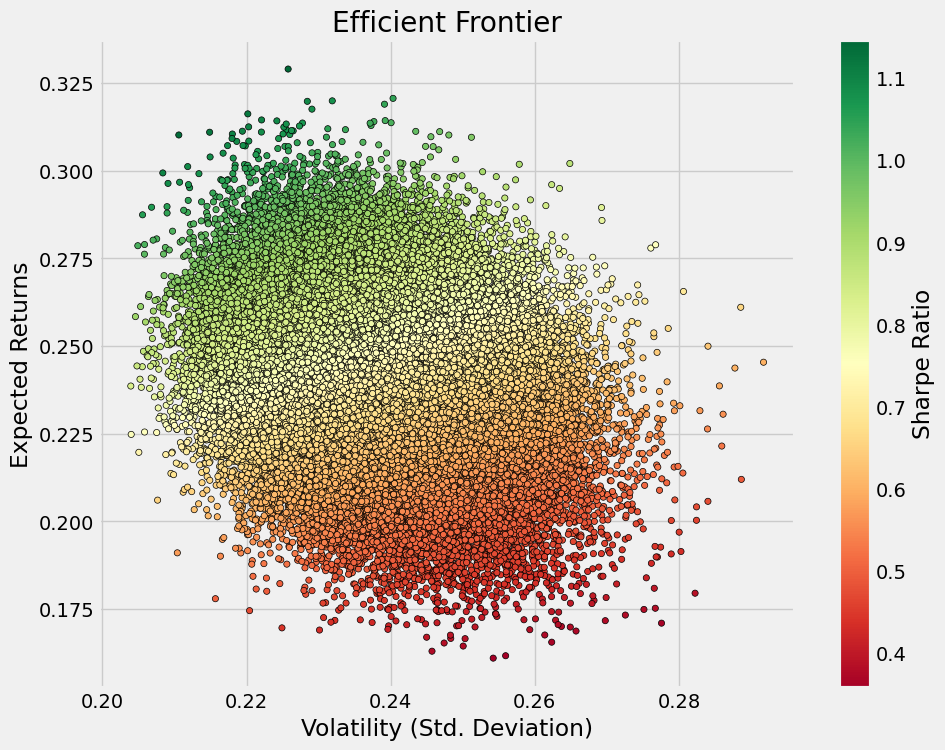

In [24]:
# PLotting the efficient frontier.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

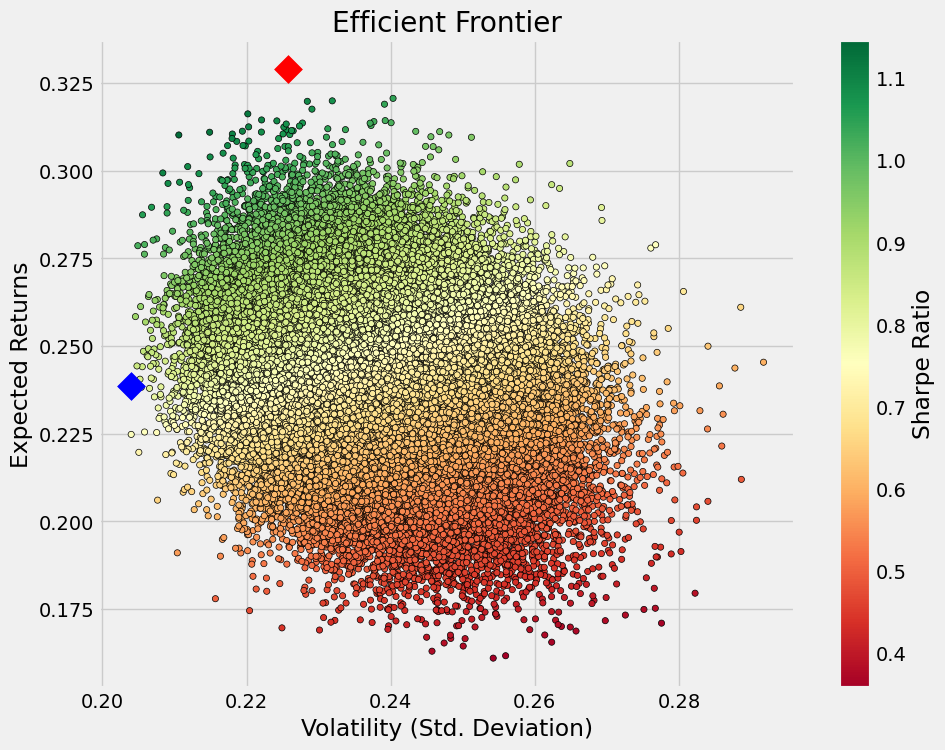

In [25]:
# Finding the Optimal Portfolio
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [26]:
r_ef = pd.concat([min_variance_port.T,sharpe_portfolio.T], axis = 1)
r_ef.columns = ["Minimum Risk Adjusted Values", "Max Risk Adjusted Values"]
print(r_ef)

                   Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                                0.238576                  0.328938
Volatility                             0.203941                  0.225773
Sharpe Ratio                           0.826593                  1.146896
5PAISA Weight                          0.033701                  0.073494
AGSTRA Weight                          0.011462                  0.008142
ANANDRATHI Weight                      0.069746                  0.038499
ANGELONE Weight                        0.038075                  0.017950
CENTRUM Weight                         0.075756                  0.025629
DCBBANK Weight                         0.058600                  0.005875
GEOJITFSL Weight                       0.021760                  0.011865
HDFCAMC Weight                         0.063964                  0.077752
IFCI Weight                            0.018227                  0.036567
INVENTURE Weight                      

In [ ]:
import scipy.optimize as sc
def portfolio_performance(weights, returns, cov_matrix):
    returns=np.sum(returns*weights)
    std=np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))
    return returns,std

# to get maximum sharpe ratio, we can minimize negative sharpe ratio
def negative_sharpe_ratio(weights,returns,cov_matrix,rfr=0.07):
    p_ret,p_std=portfolio_performance(weights,returns,cov_matrix)
    return -(p_ret-rfr)/p_std

def maxSR(returns,cov_matrix):
    rfr=0.07
    constraintSet=(0,1)
    num_assets=len(returns)
    args=(returns,cov_matrix,rfr)
    constraints=({'type':'eq','fun':lambda x: np.sum(x)-1})
    bound=constraintSet
    bounds=tuple(bound for asset in range(num_assets))
    #optimize using SLSQP (Sequential Least Squares Programming) algorithm
    result=sc.minimize(negative_sharpe_ratio, num_assets*[1./num_assets,],args=args,method='SLSQP',bounds=bounds,constraints=constraints)
    return result

result=maxSR(weighted_returns['weighted_expected_return'],covariance)
print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.7757184942643727
       x: [ 3.340e-01  3.757e-16 ...  3.670e-16  1.862e-16]
     nit: 10
     jac: [-3.156e-01  1.896e+00 ...  7.879e-01  7.952e-01]
    nfev: 245
    njev: 10


In [37]:
#multiply by 100 to get percentage and round off to 2 decimal places
display(np.round(result.x*100,2))


array([33.4 ,  0.  ,  6.98,  0.  ,  0.  ,  0.  ,  0.  , 13.13,  0.  ,
       11.37, 16.25,  0.  ,  0.  , 14.51,  0.  ,  4.37,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ])